In [1]:
import os
import sys
import random

import numpy as np
import pandas as pd
import tensorflow as tf


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import keras

from keras.metrics import MeanIoU
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from  keras_preprocessing.image   import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, schedules, Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.models import Model, load_model
from tensorflow.python.keras import losses

In [2]:
dpath = "Dataset_BUSI\Dataset_BUSI_with_GT/"

In [3]:
data = {'image' : [],
        'mask' : []}
classes = ['benign', 'malignant', 'normal']
image_height = 256
image_width = 256

In [4]:
def load_data(path, data_obj, class_name):
    img_names_list = os.listdir(path+class_name)
    image_names = []
    mask_names = []
    names_truncated = []
    
    for i in range(len(img_names_list)):
        names_truncated.append(img_names_list[i].split(')')[0])
    
    names_truncated = list(set(names_truncated))
    
    for i in range(len(names_truncated)):
        image_names.append(names_truncated[i]+').png')
        mask_names.append(names_truncated[i]+')_mask.png')
    
    data_obj = preprocess_data(image_names, mask_names, image_width, image_height, path, class_name, data_obj)
        
        
    return data_obj

In [5]:
def preprocess_data(image_names, mask_names, img_width, img_height, dpath, dclass, data_obj):
    for index in range (len(image_names)):
        image_path = dpath+'/'+dclass+'/'+ image_names[index]
        mask_path = dpath+'/'+dclass+'/'+ mask_names[index]
        
        x = cv2.imread(image_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = np.round(cv2.resize(x, (image_height, image_width)))
        x.dtype = np.uint8
        y = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        y = cv2.resize(y, (image_height, image_width))

        x= x/255.0
        y= y/255.0
        data_obj['image'].append(x)
        data_obj['mask'].append(y)

    return data_obj

In [6]:
data = load_data(dpath, data, classes[0]) 
ln = len(data['image'])
print("Number of benign tumor images", ln)
data = load_data(dpath, data, classes[1]) 
print("Number of malignant tumor images", len(data['image'])-ln)
print("Total images for segmentation", len(data['image']))

Number of benign tumor images 437
Number of malignant tumor images 210
Total images for segmentation 647


In [7]:
def visualize_example(data, index = None):
    if index is None:
        index = random.randint(0, len(data['image']))
    X = data['image']
    y = data['mask']
    has_mask = y[index].max() > 0
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(X[index])
    if has_mask:
        ax[0].set_title('Image')

    ax[1].imshow(y[index].squeeze())
    ax[1].set_title('Mask')

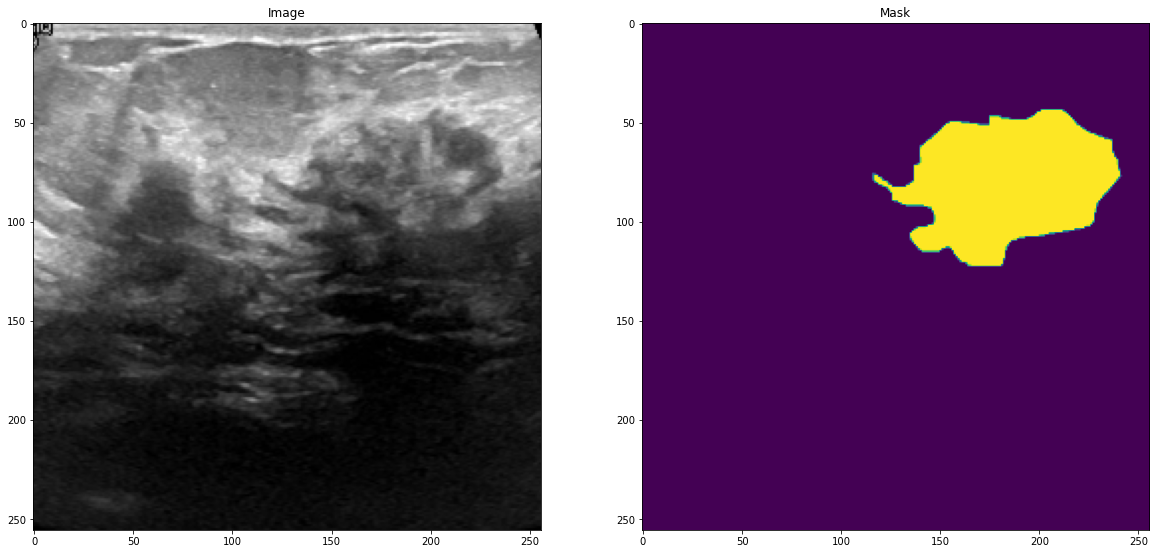

In [8]:
visualize_example(data)

In [9]:
data['image'] = np.array(data['image'])
data['image'].shape

(647, 256, 256, 3)

In [10]:
data['mask'] = np.array(data['mask'])
data['mask'] =  np.expand_dims(data['mask'], -1)
data['mask'].shape

(647, 256, 256, 1)

In [17]:
X_train, X_test, y_train, y_test  = train_test_split(data['image'], data['mask'], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print(len(X_train), len(y_train), len(X_val), len(y_val),len(X_test), len(y_test))

387 387 130 130 130 130


In [20]:
X_train = np.reshape(X_train, (len(X_train), 256, 256, 3))
y_train = np.reshape(y_train, (len(y_train), 256, 256, 1))
X_val = np.reshape(X_val, (len(X_val), 256, 256, 3))
y_val = np.reshape(y_val, (len(y_val), 256, 256, 1))
X_test = np.reshape(X_test, (len(X_test), 256, 256, 3))
y_test = np.reshape(y_test, (len(y_test), 256, 256, 1))

In [47]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Reshape
def resnet_block(input_data, filters, strides=1):
    x = Conv2D(filters, kernel_size=(3, 3), strides=strides, padding='same')(input_data)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=(3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if strides > 1:
        input_data = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='same')(input_data)

    x = Add()([x, input_data])
    x = Activation('relu')(x)
    return x


def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = resnet_block(x, filters=64, strides=1)
    x = resnet_block(x, filters=64, strides=1)
    x = resnet_block(x, filters=64, strides=1)

    x = resnet_block(x, filters=128, strides=2)
    x = resnet_block(x, filters=128, strides=1)
    x = resnet_block(x, filters=128, strides=1)
    x = resnet_block(x, filters=128, strides=1)

    x = resnet_block(x, filters=256, strides=2)
    x = resnet_block(x, filters=256, strides=1)
    x = resnet_block(x, filters=256, strides=1)
    x = resnet_block(x, filters=256, strides=1)
    x = resnet_block(x, filters=256, strides=1)
    x = resnet_block(x, filters=256, strides=1)

    x = resnet_block(x, filters=512, strides=2)
    x = resnet_block(x, filters=512, strides=1)
    x = resnet_block(x, filters=512, strides=1)

    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(256 * 256, activation='sigmoid')(x)
    x = Reshape((256, 256, 1))(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

image_width = 256  
image_height = 256  
num_channels = 3   # Görüntü kanal sayısı
input_shape = (image_width, image_height, num_channels)
num_classes = 3  

model = build_resnet(input_shape, num_classes)


#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=10, verbose=1), 
    ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_723 (Conv2D)            (None, 128, 128, 64  9472        ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_683 (Batch  (None, 128, 128, 64  256        ['conv2d_723[0][0]']             
 Normalization)                 )                                                          

 add_323 (Add)                  (None, 32, 32, 128)  0           ['batch_normalization_691[0][0]',
                                                                  'conv2d_732[0][0]']             
                                                                                                  
 activation_690 (Activation)    (None, 32, 32, 128)  0           ['add_323[0][0]']                
                                                                                                  
 conv2d_733 (Conv2D)            (None, 32, 32, 128)  147584      ['activation_690[0][0]']         
                                                                                                  
 batch_normalization_692 (Batch  (None, 32, 32, 128)  512        ['conv2d_733[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activatio

                                                                                                  
 batch_normalization_701 (Batch  (None, 16, 16, 256)  1024       ['conv2d_743[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 add_328 (Add)                  (None, 16, 16, 256)  0           ['batch_normalization_701[0][0]',
                                                                  'activation_698[0][0]']         
                                                                                                  
 activation_700 (Activation)    (None, 16, 16, 256)  0           ['add_328[0][0]']                
                                                                                                  
 conv2d_744 (Conv2D)            (None, 16, 16, 256)  590080      ['activation_700[0][0]']         
          

                                                                                                  
 conv2d_753 (Conv2D)            (None, 8, 8, 512)    2359808     ['activation_709[0][0]']         
                                                                                                  
 batch_normalization_711 (Batch  (None, 8, 8, 512)   2048        ['conv2d_753[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d_754 (Conv2D)            (None, 8, 8, 512)    131584      ['activation_708[0][0]']         
                                                                                                  
 add_333 (Add)                  (None, 8, 8, 512)    0           ['batch_normalization_711[0][0]',
                                                                  'conv2d_754[0][0]']             
          

In [48]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(patience=10, verbose=1), 
    ModelCheckpoint('model-checkpoint.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [49]:
results=model.fit(X_train, y_train, batch_size=32, epochs=18, validation_data=(X_val, y_val),callbacks=callbacks)

Epoch 1/18
13/13 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.8720
Epoch 1: val_loss improved from inf to 0.37857, saving model to model-checkpoint.h5
13/13 [==============================] - 130s 10s/step - loss: 0.4825 - accuracy: 0.8720 - val_loss: 0.3786 - val_accuracy: 0.9012
Epoch 2/18
13/13 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.9085
Epoch 2: val_loss did not improve from 0.37857
13/13 [==============================] - 119s 9s/step - loss: 0.2572 - accuracy: 0.9085 - val_loss: 0.4773 - val_accuracy: 0.9012
Epoch 3/18
13/13 [==============================] - ETA: 0s - loss: 0.2352 - accuracy: 0.9086
Epoch 3: val_loss improved from 0.37857 to 0.27741, saving model to model-checkpoint.h5
13/13 [==============================] - 130s 10s/step - loss: 0.2352 - accuracy: 0.9086 - val_loss: 0.2774 - val_accuracy: 0.9012
Epoch 4/18
13/13 [==============================] - ETA: 0s - loss: 0.2244 - accuracy: 0.9108
Epoch 4: val_

In [50]:
# Modelin performansını değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

5/5 [==============================] - 8s 1s/step - loss: 0.2767 - accuracy: 0.8930
Test loss: 0.2767425775527954
Test accuracy: 0.8930405974388123


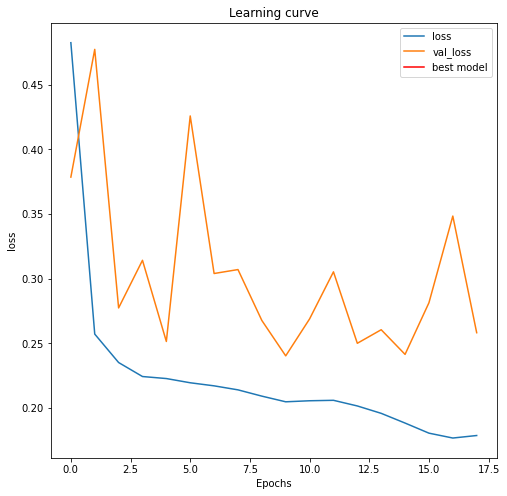

In [51]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend();

In [53]:
preds_test = model.predict(X_test, verbose=1)

5/5 [==============================] - 8s 1s/step


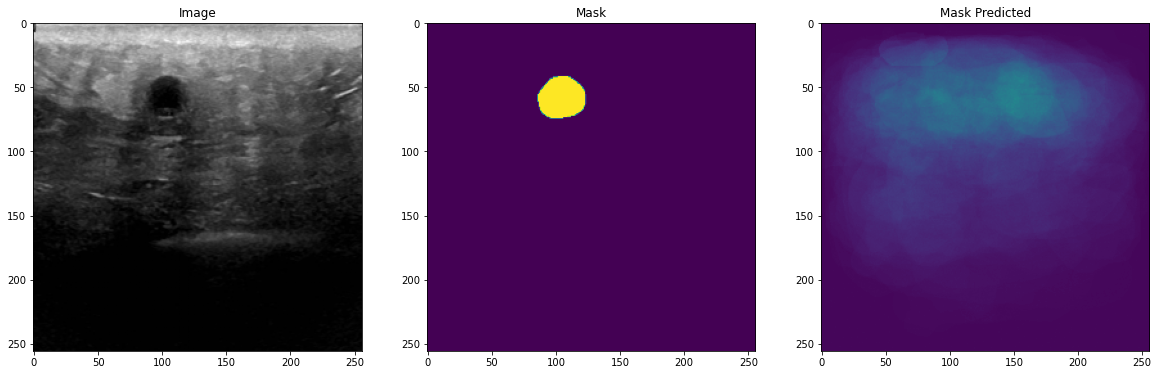

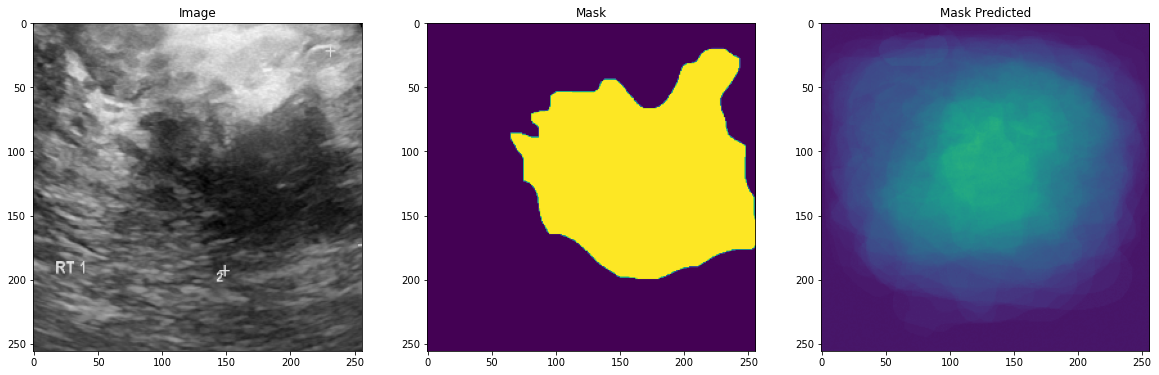

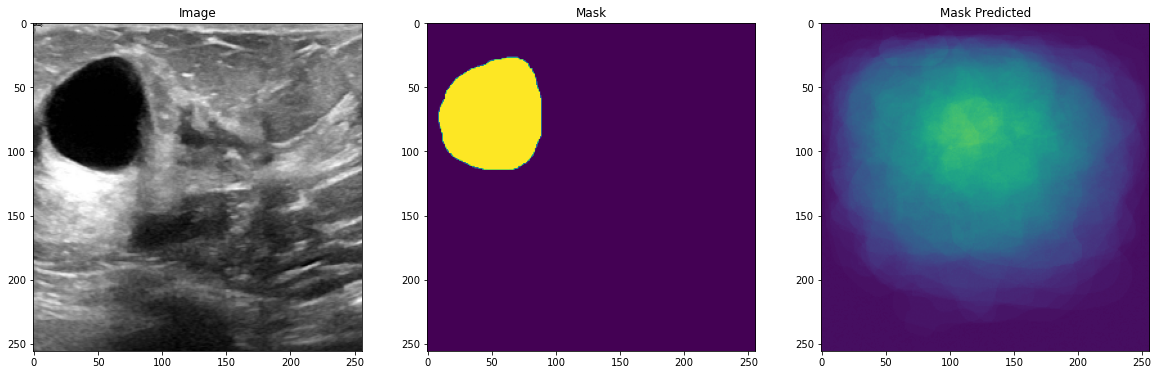

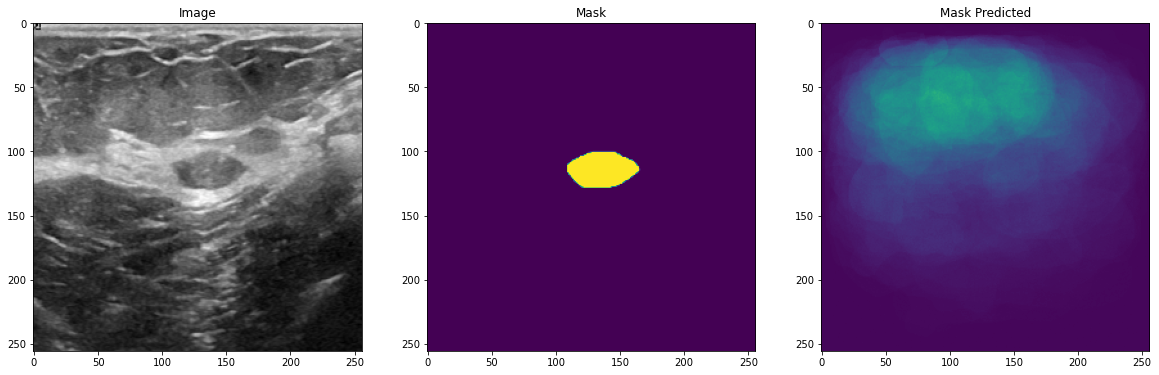

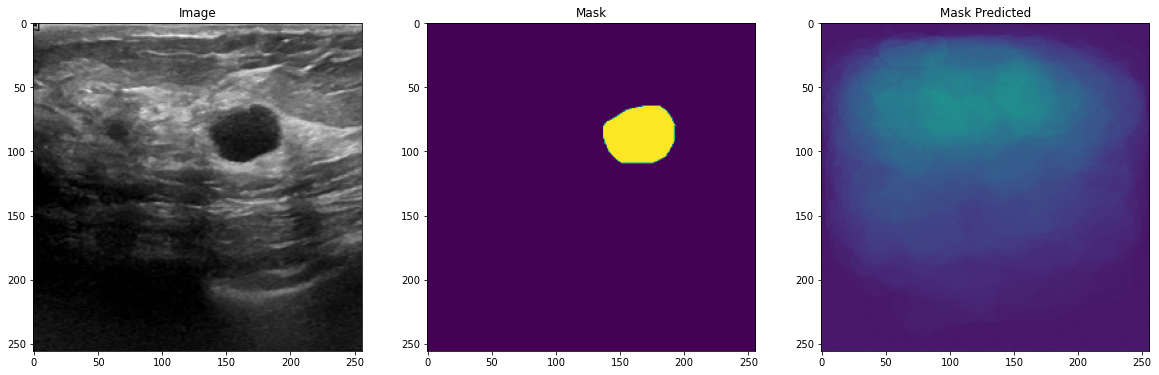

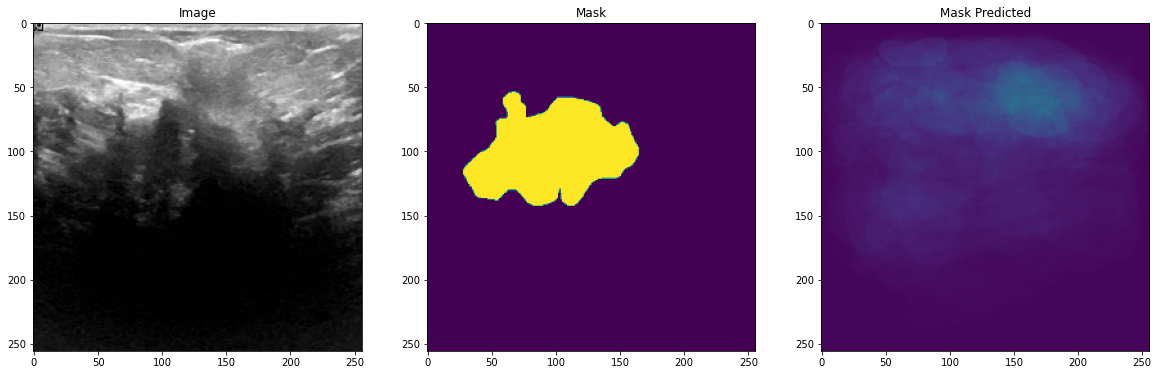

In [54]:
def plot_sample(X, y, preds, ix):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(X[ix])
    if has_mask:
        ax[0].set_title('Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    ax[2].set_title('Mask Predicted')
    
plot_sample(X_test, y_test, preds_test, 12)
plot_sample(X_test, y_test, preds_test, 17)
plot_sample(X_test, y_test, preds_test, 32)
plot_sample(X_test, y_test, preds_test, 65)
plot_sample(X_test, y_test, preds_test, 15)
plot_sample(X_test, y_test, preds_test, 96)